In [ ]:
import torch
import os
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torchvision.models as models
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
import torch.nn.functional as F
from collections import defaultdict
import random
import warnings

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed()

# ---------------------
# 1. Data Preprocessing & Augmentation
# ---------------------
def create_dataloaders(batch_size, sample_size_per_class):
    dataset_path = os.path.join(os.getcwd(), "ISIC_Data_5000") # Dataset with >5000 images per class

    # Training augmentations
    train_transform = transforms.Compose([
        transforms.Resize((320, 320)),  # Larger initial size
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # Random crop and resize to 224x224
        transforms.RandomHorizontalFlip(), # Flip horizontally  
        transforms.RandomVerticalFlip(), # Flip vertically
        transforms.RandomRotation(45), # Rotate up to 45 degrees
        transforms.ColorJitter( # Randomly adjust brightness, contrast, saturation, and hue
            brightness=0.3,
            contrast=0.3,
            saturation=0.3,
            hue=0.1
        ),
        transforms.RandomAffine( # Random affine transformation
            degrees=0,
            translate=(0.1, 0.1),
            scale=(0.9, 1.1),
            shear=10
        ),
        # Convert to tensor after PIL operations
        transforms.ToTensor(),
        # Tensor operations after conversion
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225]), # Normalize the image
        transforms.RandomErasing(p=0.2),
    ])

    # Validation and test transforms (no augmentation)
    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Load dataset without transform initially
    basic_transform = transforms.Compose([transforms.Resize((224, 224))])
    full_dataset = datasets.ImageFolder(root=dataset_path, transform=basic_transform)
    print(f"Total dataset size: {len(full_dataset)} images")
    print(f"Classes: {full_dataset.classes}")

    # Group images by class
    class_samples = defaultdict(list)
    for idx, (_, label) in enumerate(full_dataset.samples):
        class_samples[label].append(idx)

    # Print class distribution
    for class_idx, indices in class_samples.items():
        class_name = full_dataset.classes[class_idx]
        print(f"Class {class_name}: {len(indices)} images")

    # Ensure balanced dataset with specified samples per class
    fixed_indices = []
    for label, indices in class_samples.items():
        # Check if we have enough samples
        if len(indices) >= sample_size_per_class:
            # If we have more than needed, randomly select the required number
            sampled_indices = random.sample(indices, sample_size_per_class)
        else:
            # If we have fewer than needed, take all and augment with repetition
            sampled_indices = indices.copy()
            # Oversample with replacement to reach the target count (scc)
            additional_indices = random.choices(indices, k=sample_size_per_class - len(indices))
            sampled_indices.extend(additional_indices)
            print(f"Class {full_dataset.classes[label]}: Oversampled from {len(indices)} to {sample_size_per_class}")
            
        fixed_indices.extend(sampled_indices)

    # Shuffle indices
    random.shuffle(fixed_indices)

    # Split into train, val, test (80/10/10)
    split1 = int(0.8 * len(fixed_indices))
    split2 = int(0.9 * len(fixed_indices))

    train_indices = fixed_indices[:split1]
    val_indices = fixed_indices[split1:split2]
    test_indices = fixed_indices[split2:]

    # Create dataset objects with appropriate transforms
    train_dataset = datasets.ImageFolder(root=dataset_path, transform=train_transform)
    val_dataset = datasets.ImageFolder(root=dataset_path, transform=val_test_transform)
    test_dataset = datasets.ImageFolder(root=dataset_path, transform=val_test_transform)

    # Create subsets
    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(val_dataset, val_indices)
    test_subset = Subset(test_dataset, test_indices)

    print(f"Train set: {len(train_subset)} images")
    print(f"Validation set: {len(val_subset)} images")
    print(f"Test set: {len(test_subset)} images")

    # Create DataLoaders
    train_loader = DataLoader(
        train_subset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=2, 
        pin_memory=torch.cuda.is_available(),
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_subset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=2, 
        pin_memory=torch.cuda.is_available()
    )
    
    test_loader = DataLoader(
        test_subset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=2, 
        pin_memory=torch.cuda.is_available()
    )

    return train_loader, val_loader, test_loader, full_dataset.classes

# ---------------------
# 2. Model Architecture
# ---------------------
class SkinLesionClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(SkinLesionClassifier, self).__init__()
        # Use ResNet50 as backbone
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        
        # Remove the fully connected layer and replace with GAP
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully connected classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1)  # Softmax for classification
        )

    def forward(self, x):
        features = self.backbone(x)  # Extract features
        features = self.global_avg_pool(features)  # Apply GAP
        return self.classifier(features)

# ---------------------
# 3. Training Function
# ---------------------
def train_classifier(train_loader, val_loader, num_epochs, batch_size, learning_rate, class_names=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Initialize model
    num_classes = len(class_names) if class_names else 4
    model = SkinLesionClassifier(num_classes=num_classes).to(device)
    
    # Initialize AdamW optimizer
    optimizer = optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=0.01, # Weight decay (L2 regularization)
        betas=(0.9, 0.999)
    )

    # One cycle learning rate scheduler
    steps_per_epoch = len(train_loader)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=2e-3,
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
        pct_start=0.3,
        anneal_strategy='cos',
        div_factor=10,
        final_div_factor=100
    )

    # Label smoothing loss
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Enable mixed precision training if available
    use_amp = torch.cuda.is_available()
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    # Training tracking
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0.0
    patience = 5
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        train_correct = 0
        train_total = 0

        # Training loop with progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch_idx, (data, target) in enumerate(progress_bar):
            data, target = data.to(device), target.to(device)
            
            # Mixed precision training
            with torch.cuda.amp.autocast(enabled=use_amp):
                output = model(data)
                loss = criterion(output, target)

            # Gradient scaling for mixed precision
            scaler.scale(loss).backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()

            # Track metrics
            epoch_train_loss += loss.item()
            _, predicted = torch.max(output, 1)
            train_correct += (predicted == target).sum().item()
            train_total += target.size(0)
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'acc': f"{100. * train_correct / train_total:.2f}%"
            })

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_acc = 100.0 * train_correct / train_total
        train_accs.append(train_acc)

        # Validation
        model.eval()
        epoch_val_loss = 0.0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                with torch.cuda.amp.autocast(enabled=use_amp):
                    output = model(data)
                    loss = criterion(output, target)
                
                epoch_val_loss += loss.item()
                _, predicted = torch.max(output, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_acc = accuracy_score(all_targets, all_preds) * 100.0
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"  [*] Best model saved with val_acc = {val_acc:.2f}%")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs")
                break

    # Plot training curves
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()
    
    print(f"Training complete. Best validation accuracy: {best_val_acc:.2f}%")
    return model

# ---------------------
# 4. Test-Time Augmentation (TTA) for Evaluation
# ---------------------
def tta_predict(model, img, device):
    tta_transforms = [
        # Original image (identity transform)
        transforms.Compose([
            lambda x: x  # Identity function
        ]),
        
        # Horizontal flip (tensor operation)
        transforms.Compose([
            lambda x: torch.flip(x, dims=[-1])  # Horizontal flip for tensor
        ]),
        
        # Vertical flip (tensor operation)
        transforms.Compose([
            lambda x: torch.flip(x, dims=[-2])  # Vertical flip for tensor
        ]),
        
        # Both flips
        transforms.Compose([
            lambda x: torch.flip(x, dims=[-1, -2])  # Both flips
        ]),
    ]
    
    # Apply each transformation and get predictions
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for transform in tta_transforms:
            # Apply transformation on tensor directly
            try:
                # Clone the tensor to avoid modifying the original
                aug_img = transform(img.clone()).unsqueeze(0).to(device)
                with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                    output = model(aug_img)
                predictions.append(output)
            except Exception as e:
                print(f"TTA transform error: {e}")
                continue
    
    # Average the predictions
    if predictions:
        final_prediction = torch.mean(torch.stack(predictions), dim=0)
        return final_prediction
    else:
        # Fallback to regular prediction if TTA fails
        with torch.no_grad():
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                return model(img.unsqueeze(0))

# ---------------------
# 5. Evaluation Function
# ---------------------
def evaluate_model(test_loader, class_names, use_tta=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load best model
    num_classes = len(class_names)
    model = SkinLesionClassifier(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()

    all_preds = []
    all_targets = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            if use_tta:
                # Process batch with TTA
                outputs_list = []
                
                # Original images
                with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                    outputs = model(inputs)
                outputs_list.append(outputs)
                
                # Horizontal flip
                with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                    flipped_h = torch.flip(inputs, dims=[-1])  # Horizontal flip
                    outputs_h = model(flipped_h)
                outputs_list.append(outputs_h)
                
                # Vertical flip
                with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                    flipped_v = torch.flip(inputs, dims=[-2])  # Vertical flip
                    outputs_v = model(flipped_v)
                outputs_list.append(outputs_v)
                
                # Average predictions
                outputs = torch.mean(torch.stack(outputs_list), dim=0)
            else:
                # Standard inference without TTA
                with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                    outputs = model(inputs)
            
            # Get predictions and probabilities
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_preds) * 100
    precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)

    print(f"\nTest Results {'(with TTA)' if use_tta else '(without TTA)'}:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Per-class metrics
    for i, class_name in enumerate(class_names):
        class_precision = precision_score(
            [1 if t == i else 0 for t in all_targets],
            [1 if p == i else 0 for p in all_preds],
            zero_division=0
        )
        class_recall = recall_score(
            [1 if t == i else 0 for t in all_targets],
            [1 if p == i else 0 for p in all_preds],
            zero_division=0
        )
        class_f1 = f1_score(
            [1 if t == i else 0 for t in all_targets],
            [1 if p == i else 0 for p in all_preds],
            zero_division=0
        )
        
        class_samples = sum(1 for t in all_targets if t == i)
        class_correct = sum(1 for t, p in zip(all_targets, all_preds) if t == i and p == i)
        class_acc = (class_correct / class_samples * 100) if class_samples > 0 else 0
        
        print(f"\nClass: {class_name}")
        print(f"  Samples: {class_samples}")
        print(f"  Accuracy: {class_acc:.2f}%")
        print(f"  Precision: {class_precision:.4f}")
        print(f"  Recall: {class_recall:.4f}")
        print(f"  F1-score: {class_f1:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    # Plot class accuracies as a bar graph
    class_accuracies = []
    for i, class_name in enumerate(class_names):
        class_samples = sum(1 for t in all_targets if t == i)
        class_correct = sum(1 for t, p in zip(all_targets, all_preds) if t == i and p == i)
        class_acc = (class_correct / class_samples * 100) if class_samples > 0 else 0
        class_accuracies.append(class_acc)
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_names, class_accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy by Class')
    plt.ylim(0, 100)
    
    # Add accuracy values on top of bars
    for bar, acc in zip(bars, class_accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('class_accuracies.png')
    plt.show()
    
    # PCA visualization of feature space
    visualize_feature_space(test_loader, model, device, class_names)
    
    return accuracy, precision, recall, f1

# ---------------------
# 6. Feature Space Visualization
# ---------------------
def visualize_feature_space(test_loader, model, device, class_names):
    model.eval()
    features = []
    labels = []
    
    # Get the penultimate layer output (features before the final classification layer)
    def get_features(model, x):
        # For ResNet50, we need the features before the final fully connected layer
        # Pass through the model except the classifier
        x = model.backbone(x)
        return x
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Extracting features"):
            inputs = inputs.to(device)
            batch_features = get_features(model, inputs)
            features.append(batch_features.cpu().numpy())
            labels.extend(targets.numpy())
    
    # Concatenate all features
    features = np.vstack(features)
    
    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(features)
    
    # Plot reduced features
    plt.figure(figsize=(12, 10))
    
    # Create a scatter plot with different colors for each class
    for i, class_name in enumerate(class_names):
        mask = [label == i for label in labels]
        plt.scatter(
            reduced_features[mask, 0],
            reduced_features[mask, 1],
            alpha=0.7,
            label=class_name
        )
    
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("Feature Space Visualization (PCA)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig('feature_space.png')
    plt.show()
    
    # Print explained variance
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance by 2 principal components: {sum(explained_variance)*100:.2f}%")
    print(f"Component 1: {explained_variance[0]*100:.2f}%")
    print(f"Component 2: {explained_variance[1]*100:.2f}%")

# ---------------------
# 7. Main Execution
# ---------------------
def main(sample_size_per_class, batch_size, num_epochs, learning_rate):
    print(f"Running with {sample_size_per_class} samples per class")

    # Create dataloaders
    train_loader, val_loader, test_loader, class_names = create_dataloaders(
        batch_size=batch_size, 
        sample_size_per_class=sample_size_per_class
    )

    # Train model
    train_classifier(train_loader, val_loader, num_epochs, batch_size, learning_rate, class_names)

    # Evaluate model with TTA
    evaluate_model(test_loader, class_names, use_tta=True)
    
    # Evaluate model without TTA for comparison
    evaluate_model(test_loader, class_names, use_tta=False)

Running with 5000 samples per class
Total dataset size: 23361 images
Classes: ['bcc', 'benign', 'melanoma', 'scc']
Class bcc: 6801 images
Class benign: 7324 images
Class melanoma: 6906 images
Class scc: 2330 images
Class scc: Oversampled from 2330 to 5000
Train set: 16000 images
Validation set: 2000 images
Test set: 2000 images
Using device: cuda


Epoch 1/30: 100%|██████████| 500/500 [03:16<00:00,  2.54it/s, loss=1.3057, acc=42.66%]


Epoch [1/30] Train Loss: 1.2823, Val Loss: 1.0786, Train Acc: 42.66%, Val Acc: 57.80%
  [*] Best model saved with val_acc = 57.80%


Epoch 2/30: 100%|██████████| 500/500 [03:10<00:00,  2.62it/s, loss=1.0216, acc=53.45%]


Epoch [2/30] Train Loss: 1.1330, Val Loss: 0.9877, Train Acc: 53.45%, Val Acc: 63.70%
  [*] Best model saved with val_acc = 63.70%


Epoch 3/30: 100%|██████████| 500/500 [03:13<00:00,  2.58it/s, loss=1.0337, acc=59.33%]


Epoch [3/30] Train Loss: 1.0490, Val Loss: 0.9174, Train Acc: 59.33%, Val Acc: 68.40%
  [*] Best model saved with val_acc = 68.40%


Epoch 4/30: 100%|██████████| 500/500 [03:10<00:00,  2.62it/s, loss=0.8271, acc=63.35%]


Epoch [4/30] Train Loss: 0.9936, Val Loss: 0.8611, Train Acc: 63.35%, Val Acc: 72.50%
  [*] Best model saved with val_acc = 72.50%


Epoch 5/30: 100%|██████████| 500/500 [03:05<00:00,  2.69it/s, loss=0.7982, acc=67.82%]


Epoch [5/30] Train Loss: 0.9402, Val Loss: 0.8244, Train Acc: 67.82%, Val Acc: 74.00%
  [*] Best model saved with val_acc = 74.00%


Epoch 6/30: 100%|██████████| 500/500 [03:09<00:00,  2.63it/s, loss=0.9761, acc=70.58%]


Epoch [6/30] Train Loss: 0.8876, Val Loss: 0.7982, Train Acc: 70.58%, Val Acc: 75.70%
  [*] Best model saved with val_acc = 75.70%


Epoch 7/30: 100%|██████████| 500/500 [03:06<00:00,  2.69it/s, loss=0.8579, acc=71.49%]


Epoch [7/30] Train Loss: 0.8820, Val Loss: 0.8022, Train Acc: 71.49%, Val Acc: 75.65%


Epoch 8/30: 100%|██████████| 500/500 [03:08<00:00,  2.66it/s, loss=0.7979, acc=71.46%]


Epoch [8/30] Train Loss: 0.8790, Val Loss: 0.8141, Train Acc: 71.46%, Val Acc: 74.30%


Epoch 9/30: 100%|██████████| 500/500 [03:09<00:00,  2.63it/s, loss=0.7785, acc=73.33%]


Epoch [9/30] Train Loss: 0.8467, Val Loss: 0.7269, Train Acc: 73.33%, Val Acc: 79.50%
  [*] Best model saved with val_acc = 79.50%


Epoch 10/30: 100%|██████████| 500/500 [03:08<00:00,  2.65it/s, loss=0.9198, acc=77.74%]


Epoch [10/30] Train Loss: 0.7727, Val Loss: 0.7535, Train Acc: 77.74%, Val Acc: 79.00%


Epoch 11/30: 100%|██████████| 500/500 [03:02<00:00,  2.74it/s, loss=0.7217, acc=78.40%]


Epoch [11/30] Train Loss: 0.7614, Val Loss: 0.7001, Train Acc: 78.40%, Val Acc: 81.40%
  [*] Best model saved with val_acc = 81.40%


Epoch 12/30: 100%|██████████| 500/500 [03:04<00:00,  2.71it/s, loss=0.7938, acc=80.19%]


Epoch [12/30] Train Loss: 0.7320, Val Loss: 0.7138, Train Acc: 80.19%, Val Acc: 81.50%
  [*] Best model saved with val_acc = 81.50%


Epoch 13/30: 100%|██████████| 500/500 [03:04<00:00,  2.72it/s, loss=0.6299, acc=81.42%]


Epoch [13/30] Train Loss: 0.7084, Val Loss: 0.6834, Train Acc: 81.42%, Val Acc: 83.05%
  [*] Best model saved with val_acc = 83.05%


Epoch 14/30: 100%|██████████| 500/500 [03:04<00:00,  2.71it/s, loss=0.7138, acc=84.49%]


Epoch [14/30] Train Loss: 0.6571, Val Loss: 0.6511, Train Acc: 84.49%, Val Acc: 84.40%
  [*] Best model saved with val_acc = 84.40%


Epoch 15/30: 100%|██████████| 500/500 [03:03<00:00,  2.72it/s, loss=0.5063, acc=85.59%]


Epoch [15/30] Train Loss: 0.6389, Val Loss: 0.6738, Train Acc: 85.59%, Val Acc: 83.60%


Epoch 16/30: 100%|██████████| 500/500 [03:05<00:00,  2.69it/s, loss=0.6317, acc=83.87%]


Epoch [16/30] Train Loss: 0.6709, Val Loss: 0.6790, Train Acc: 83.87%, Val Acc: 82.70%


Epoch 17/30: 100%|██████████| 500/500 [03:09<00:00,  2.64it/s, loss=0.5517, acc=84.38%]


Epoch [17/30] Train Loss: 0.6593, Val Loss: 0.6888, Train Acc: 84.38%, Val Acc: 82.35%


Epoch 18/30: 100%|██████████| 500/500 [03:08<00:00,  2.65it/s, loss=0.5408, acc=85.43%]


Epoch [18/30] Train Loss: 0.6341, Val Loss: 0.6800, Train Acc: 85.43%, Val Acc: 83.50%


Epoch 19/30: 100%|██████████| 500/500 [03:03<00:00,  2.73it/s, loss=0.6446, acc=87.20%]


Epoch [19/30] Train Loss: 0.6029, Val Loss: 0.6681, Train Acc: 87.20%, Val Acc: 83.80%
Early stopping triggered after 19 epochs


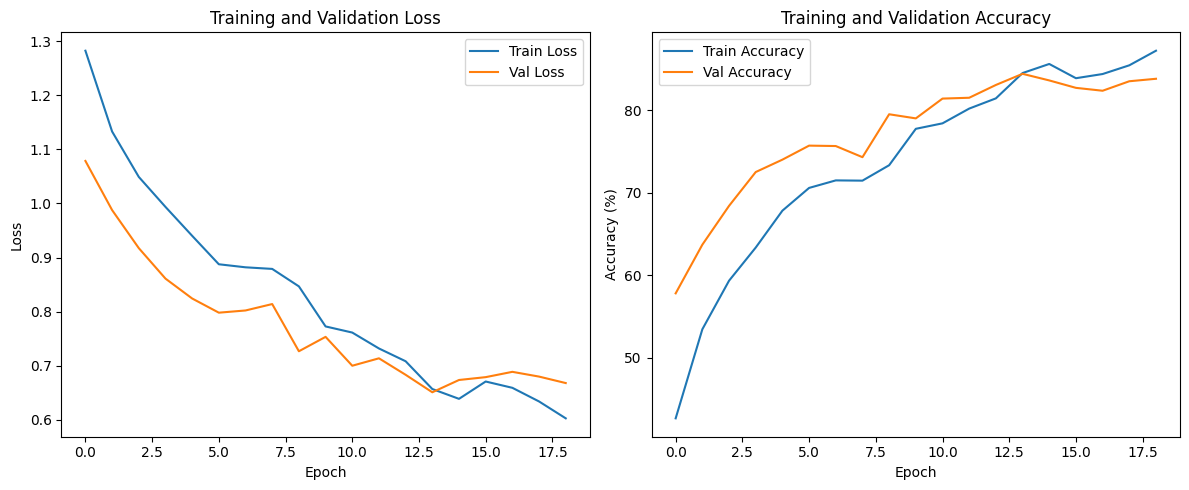

Training complete. Best validation accuracy: 84.40%


Evaluating: 100%|██████████| 63/63 [00:22<00:00,  2.81it/s]



Test Results (with TTA):
Accuracy: 84.70%
Precision: 0.8471
Recall: 0.8482
F1-score: 0.8464

Class: bcc
  Samples: 514
  Accuracy: 88.52%
  Precision: 0.8243
  Recall: 0.8852
  F1-score: 0.8537

Class: benign
  Samples: 517
  Accuracy: 73.50%
  Precision: 0.8389
  Recall: 0.7350
  F1-score: 0.7835

Class: melanoma
  Samples: 460
  Accuracy: 88.26%
  Precision: 0.8371
  Recall: 0.8826
  F1-score: 0.8593

Class: scc
  Samples: 509
  Accuracy: 89.00%
  Precision: 0.8882
  Recall: 0.8900
  F1-score: 0.8891


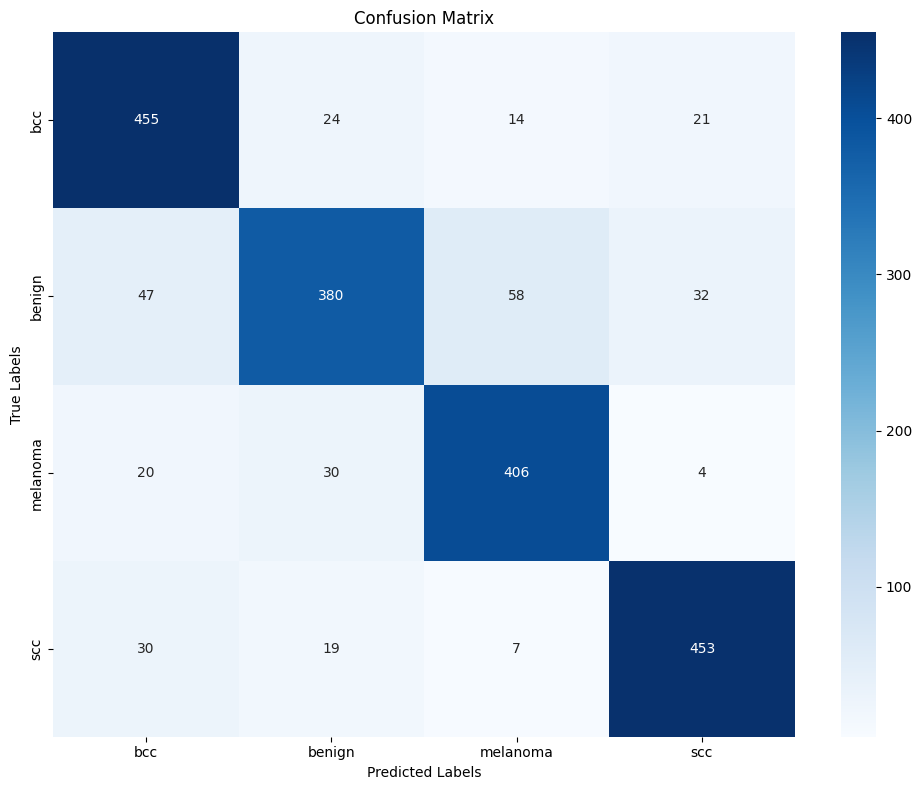

Extracting features: 100%|██████████| 63/63 [00:22<00:00,  2.75it/s]


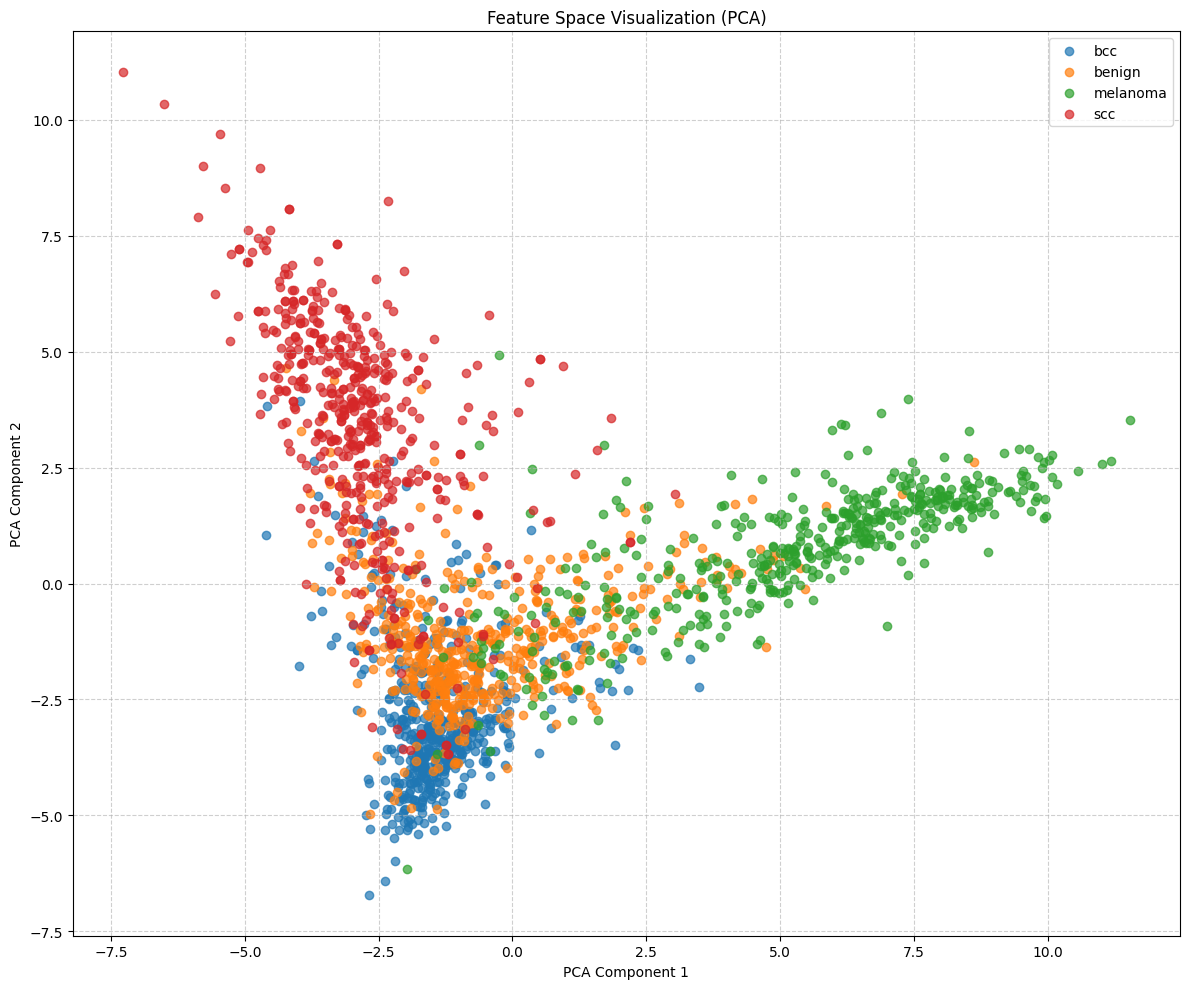

Explained variance by 2 principal components: 34.61%
Component 1: 20.55%
Component 2: 14.06%


Evaluating: 100%|██████████| 63/63 [00:22<00:00,  2.82it/s]


Test Results (without TTA):
Accuracy: 83.80%
Precision: 0.8387
Recall: 0.8392
F1-score: 0.8377

Class: bcc
  Samples: 514
  Accuracy: 88.13%
  Precision: 0.8089
  Recall: 0.8813
  F1-score: 0.8436

Class: benign
  Samples: 517
  Accuracy: 73.31%
  Precision: 0.8257
  Recall: 0.7331
  F1-score: 0.7766

Class: melanoma
  Samples: 460
  Accuracy: 87.39%
  Precision: 0.8289
  Recall: 0.8739
  F1-score: 0.8508

Class: scc
  Samples: 509
  Accuracy: 86.84%
  Precision: 0.8911
  Recall: 0.8684
  F1-score: 0.8796


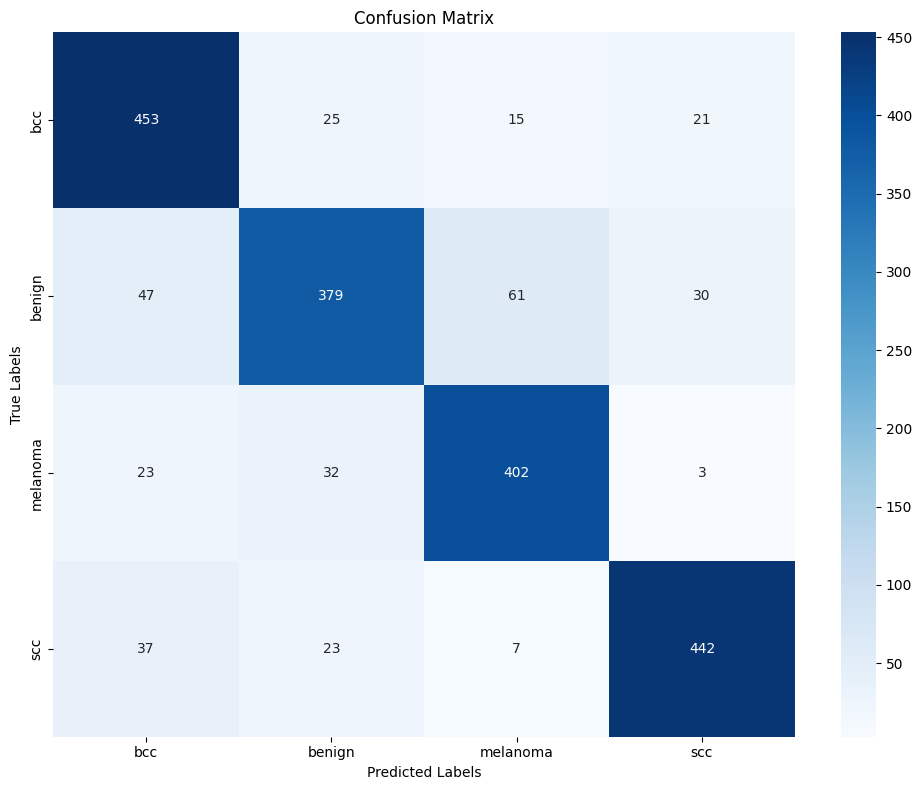

Extracting features: 100%|██████████| 63/63 [00:22<00:00,  2.75it/s]


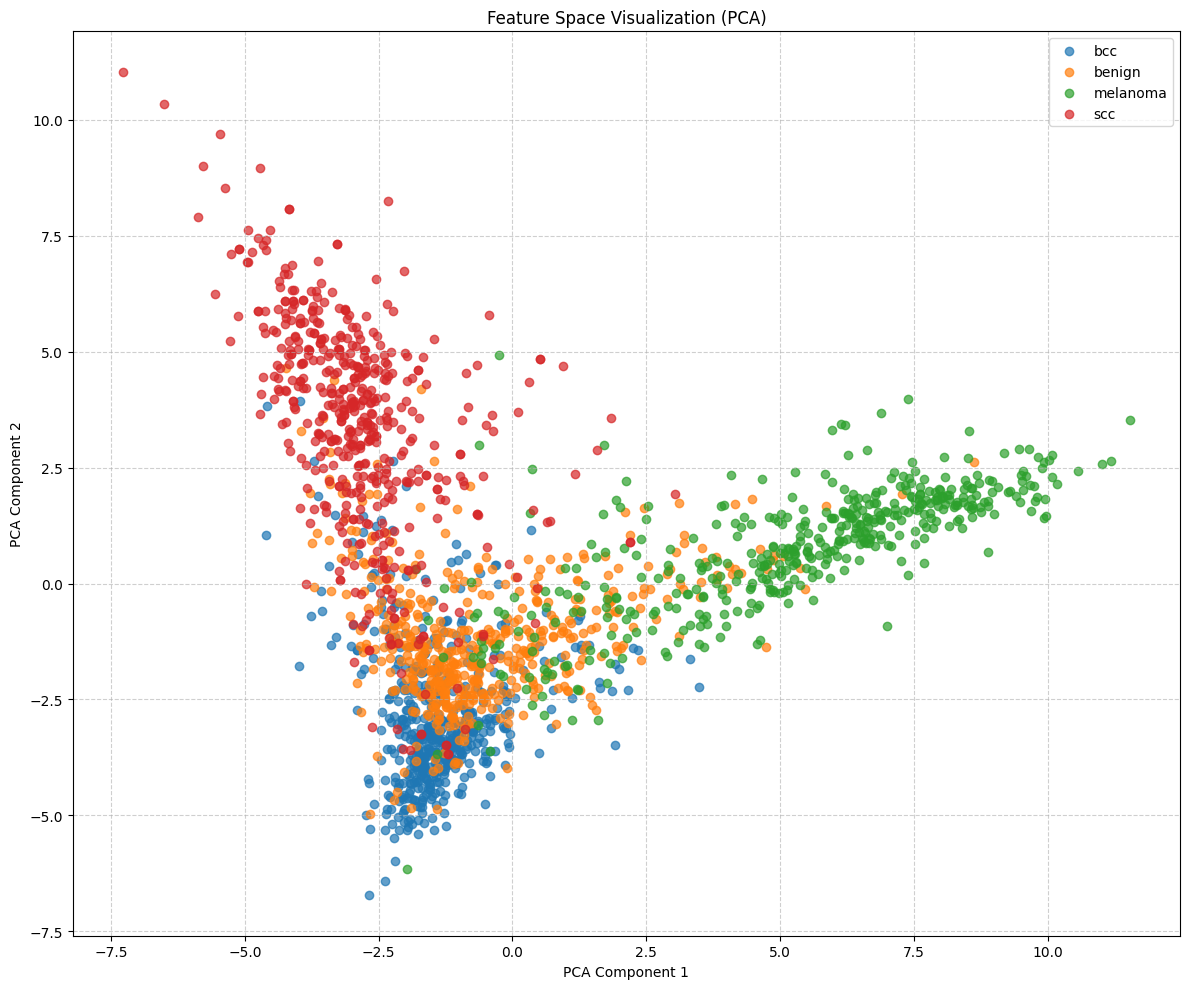

Explained variance by 2 principal components: 34.61%
Component 1: 20.55%
Component 2: 14.06%


In [ ]:
main(sample_size_per_class=5000, batch_size=32, num_epochs=30, learning_rate=1e-3)
